In [2]:
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
from monai.networks.nets import AutoEncoder
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()])
train_validation_dataset = datasets.FashionMNIST('data', train = True, download=True, transform=transform)
train_dataset, valid_dataset = random_split(train_validation_dataset, [0.8, 0.2])
test_dataset = datasets.FashionMNIST('data', train = False, download=True,transform=transform)

In [4]:
def visualize(image, label):
  plt.figure()
  plt.imshow(image, cmap='gray')
  plt.title(str(label))
  plt.xticks([])
  plt.yticks([])


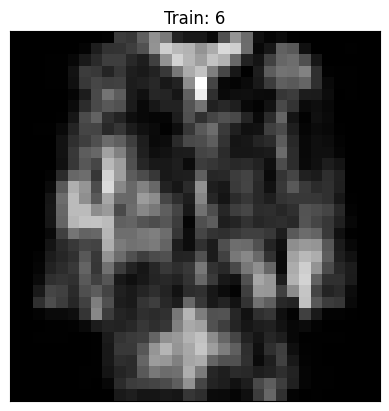

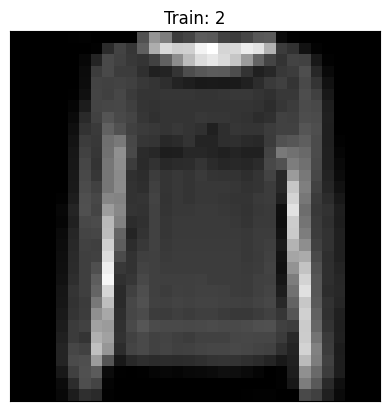

In [5]:
train_examples = [train_dataset[i] for i in range(2)]
for image, label in train_examples:
  visualize(image.numpy()[0], f'Train: {label}')

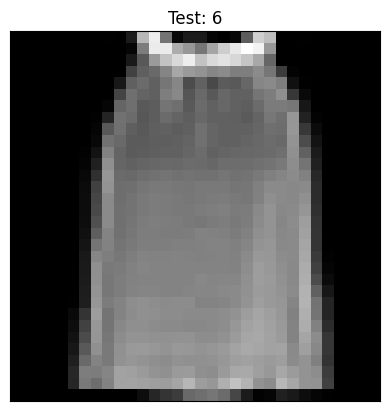

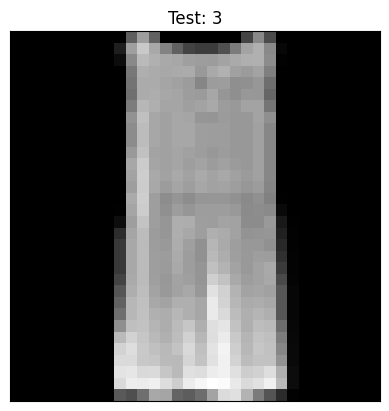

In [6]:
train_examples = [valid_dataset[i] for i in range(2)]
for image, label in train_examples:
  visualize(image.numpy()[0], f'Test: {label}')


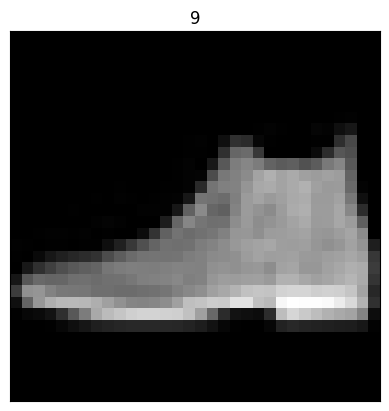

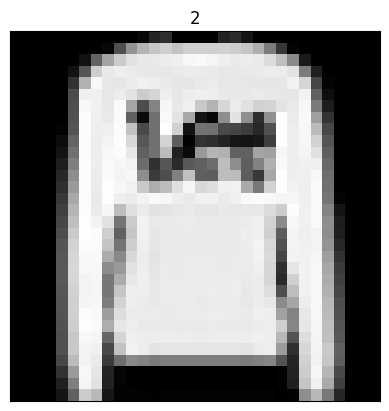

In [7]:
test_examples = [test_dataset[i] for i in range(2)]
for image, label in test_examples:
  visualize(image.numpy()[0], label)

In [57]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.InstanceNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [58]:
model = Autoencoder()
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): ReLU()
    (5): ConvTran

In [59]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [61]:
def evaluation(model, loader, criterion, device, phase='Valid'):
  model.eval()
  predictions = []
  ground_truth = []
  with torch.no_grad():
    total_loss = 0
    total  = 0
    correct = 0
    for batch_index, (images, _) in enumerate(loader):
      images = images.to(device)
      outputs = model(images)
      loss = criterion(outputs, images)
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
    loss = total_loss / total
    print(f'     {phase} Loss= {loss:<10.4f}')
    return loss



In [62]:
def training(model, train_loader, valid_loader, criterion, optimizer, device,
             epochs, best_model_path):
  model.train()
  best_loss = torch.inf
  best_restults = None
  for epoch in range(epochs):
    total_loss = 0
    total  = 0
    for batch_index, (images, _) in enumerate(train_loader):
      optimizer.zero_grad()
      images = images.to(device)
      outputs = model(images)
      loss = criterion(outputs, images)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * images.size(0)
      total += images.size(0)
    loss = total_loss / total
    print(f'{epoch:<4} Train Loss= {loss:<10.4f}')
    result = evaluation(model, valid_loader, criterion, device)
    if result < best_loss:
      torch.save(model, best_model_path)
      best_loss = result
      best_restult = result
    print()
  return best_restults




In [70]:
epochs = 100
best_model_path = 'best_model.pt'
best_restults = training(model, train_loader, valid_loader, criterion,
                         optimizer, device, epochs, best_model_path)

0    Train Loss= 0.0110    
     Valid Loss= 0.0111    

1    Train Loss= 0.0107    
     Valid Loss= 0.0107    

2    Train Loss= 0.0103    
     Valid Loss= 0.0104    

3    Train Loss= 0.0101    
     Valid Loss= 0.0102    

4    Train Loss= 0.0098    
     Valid Loss= 0.0100    

5    Train Loss= 0.0096    
     Valid Loss= 0.0098    

6    Train Loss= 0.0094    
     Valid Loss= 0.0095    

7    Train Loss= 0.0092    
     Valid Loss= 0.0094    

8    Train Loss= 0.0090    
     Valid Loss= 0.0092    

9    Train Loss= 0.0089    
     Valid Loss= 0.0090    

10   Train Loss= 0.0087    
     Valid Loss= 0.0089    

11   Train Loss= 0.0086    
     Valid Loss= 0.0088    

12   Train Loss= 0.0085    
     Valid Loss= 0.0088    

13   Train Loss= 0.0083    
     Valid Loss= 0.0085    

14   Train Loss= 0.0082    
     Valid Loss= 0.0084    

15   Train Loss= 0.0081    
     Valid Loss= 0.0083    

16   Train Loss= 0.0080    
     Valid Loss= 0.0082    

17   Train Loss= 0.0079    
   

## Testing the last model


In [71]:
results = evaluation(model, test_loader, criterion, device, 'Test')

     Test Loss= 0.0054    


In [72]:
best_model = torch.load(best_model_path)
results = evaluation(best_model, test_loader, criterion, device, 'Test')

     Test Loss= 0.0054    


In [73]:
def predict(model, loader, device):
  model.eval()
  predictions = []
  with torch.no_grad():
    for batch_index, (images, _) in enumerate(loader):
      images = images.to(device)
      outputs = model(images)
      outputs = outputs.cpu().numpy()
      outputs = [outputs[i] for i in range(outputs.shape[0])]
      predictions.extend(outputs)
  return predictions

In [74]:
def visualize(image, prediction):
  image = np.squeeze(image)
  prediction = np.squeeze(prediction)
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(image, cmap='gray')
  axes[0].axis('off')
  axes[0].set_title('Image')
  axes[1].imshow(prediction, cmap='gray')
  axes[1].axis('off')
  axes[1].set_title('Prediction')

In [75]:
predictions = predict(best_model, test_loader, device)

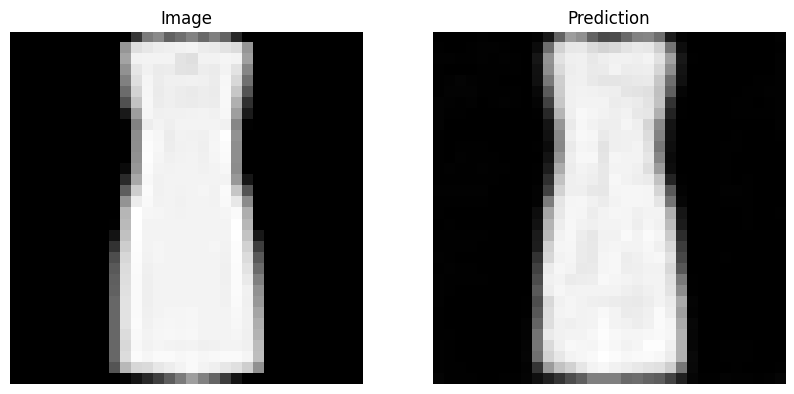

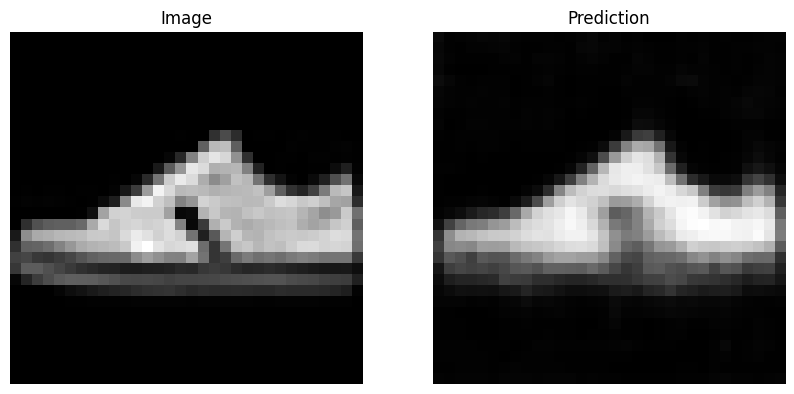

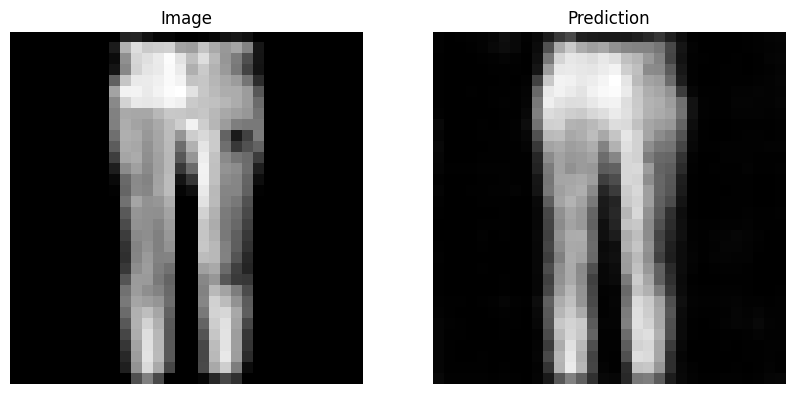

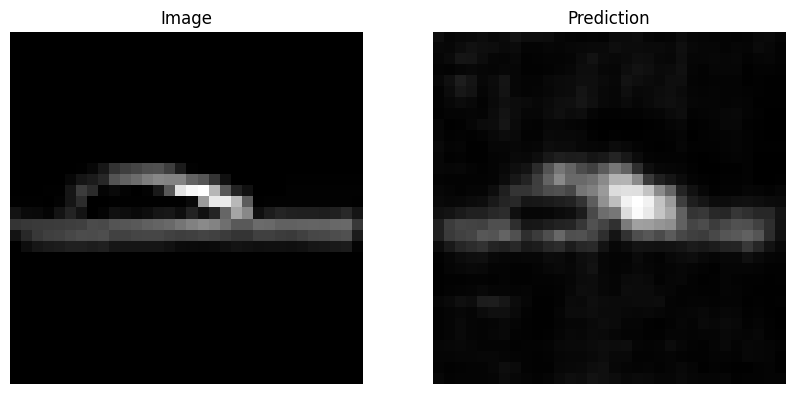

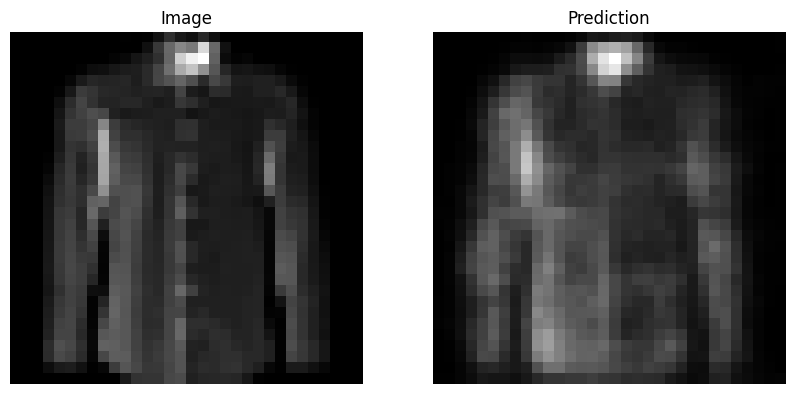

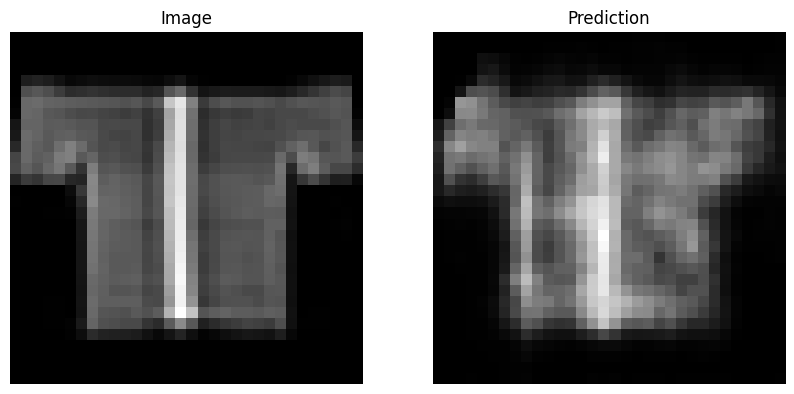

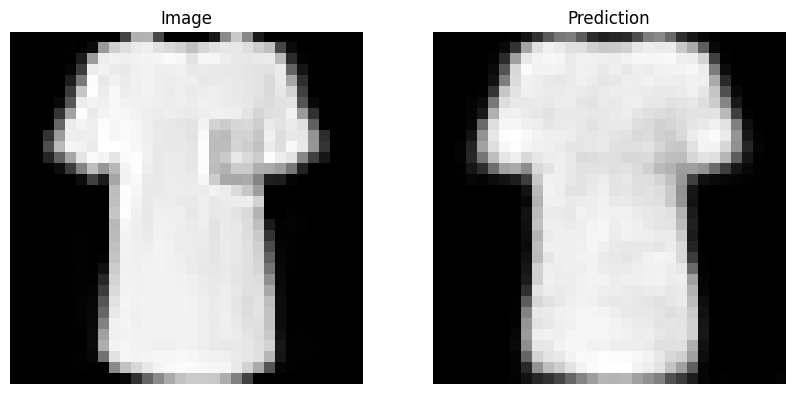

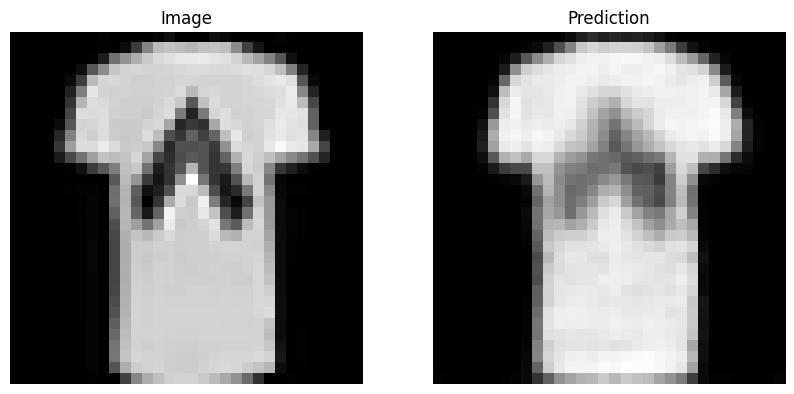

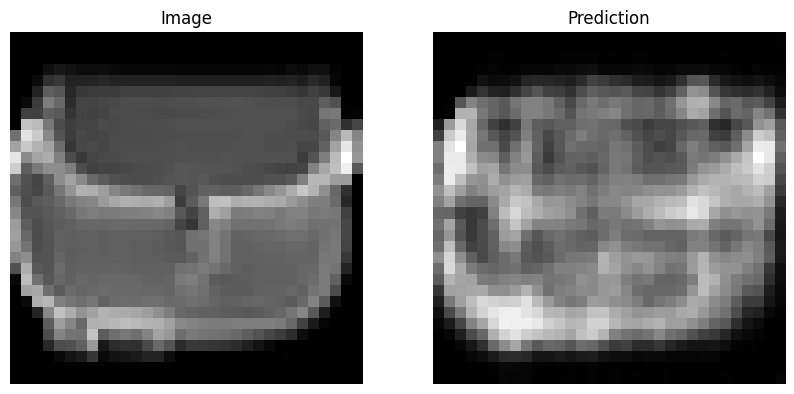

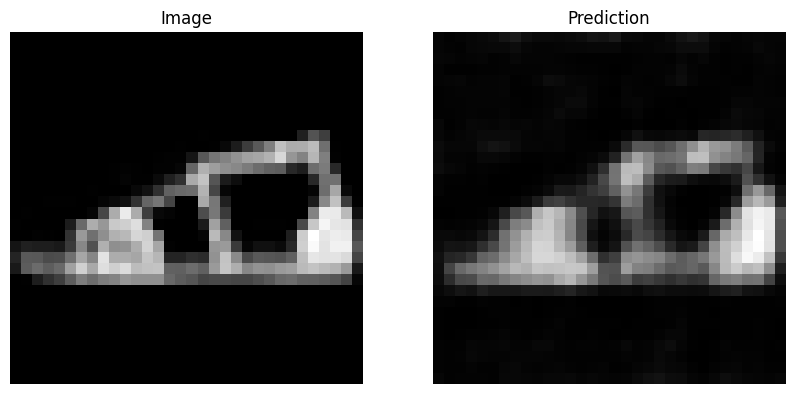

In [91]:
num_samples = 10
random_samples = np.random.choice(len(test_dataset), num_samples)
for i in random_samples:
  visualize(np.squeeze(test_dataset[i][0]), predictions[i])